In [1]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import re

In [3]:
import warnings
warnings.filterwarnings('ignore')

# user.json

In [4]:
# data = {'user_id': [], 'name': [], 'review_count': [], 'yelping_since': [], 'friends': [], 'useful': [], 'funny': [], 'cool': [], 'fans': [], 'elite': [], 'average_stars':[], 'compliment_hot': [], 'compliment_more': [], 'compliment_profile': [], 'compliment_cute': [], 'compliment_list': [], 'compliment_note': [], 'compliment_plain': [], 'compliment_cool': [], 'compliment_funny': [], 'compliment_writer': [], 'compliment_photos': []}

# with open('user.json') as f:
#     for line in tqdm(f):
#         review = json.loads(line)
#         data['user_id'].append(review['user_id'])
#         data['name'].append(review['name'])
#         data['review_count'].append(review['review_count'])
#         data['yelping_since'].append(review['yelping_since'])
#         data['friends'].append(review['friends'])
#         data['useful'].append(review['useful'])
#         data['funny'].append(review['funny'])
#         data['cool'].append(review['cool'])
#         data['fans'].append(review['fans'])
#         data['elite'].append(review['elite'])
#         data['average_stars'].append(review['average_stars'])
#         data['compliment_hot'].append(review['compliment_hot'])
#         data['compliment_more'].append(review['compliment_more'])
#         data['compliment_profile'].append(review['compliment_profile'])
#         data['compliment_cute'].append(review['compliment_cute'])
#         data['compliment_list'].append(review['compliment_list'])
#         data['compliment_note'].append(review['compliment_note'])
#         data['compliment_plain'].append(review['compliment_plain'])
#         data['compliment_cool'].append(review['compliment_cool'])
#         data['compliment_funny'].append(review['compliment_funny'])
#         data['compliment_writer'].append(review['compliment_writer'])
#         data['compliment_photos'].append(review['compliment_photos'])

In [5]:
# user_df = pd.DataFrame(data)
# user_df.head()

In [6]:
# user_df.shape

In [7]:
# pd.set_option('float_format', '{:.3f}'.format)
# user_df.describe()

# CSV file from 'business.json'

In [8]:
# Reading in 'extacted_restaurants_from_business.csv'
rest_biz_csvTOpd = pd.read_csv('extracted_restaurants_from_business.csv')

In [341]:
# Business IDs for the restaurants
restaurant_id_list = rest_biz_csvTOpd.business_id.tolist()
restaurant_id_list[:5]

['QXAEGFB4oINsVuTFxEYKFQ',
 'gnKjwL_1w79qoiV3IC_xQQ',
 '1Dfx3zM-rW4n-31KeC8sJg',
 'fweCYi8FmbJXHCqLnwuk8w',
 'PZ-LZzSlhSe9utkQYU8pFg']

In [10]:
print('Number of restaurants in the original dataset:',len(restaurant_id_list))

Number of restaurants in the original dataset: 59371


# CSV file from 'review.json'

In [11]:
# Reading in 'extracted_restaurants_from_review.csv'
rest_review_csvTOpd = pd.read_csv('extracted_restaurants_from_review.csv')

In [12]:
# Rename column containing the old indices
rest_review_csvTOpd.rename(columns={"Unnamed: 0": "Index_From_review.JSON"})

,Index_From_review.JSON,review_id,business_id,stars,text
0,3,yi0R0Ugj_xUx_Nek0-_Qig,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
1,5,fdiNeiN_hoCxCMy2wTRW9g,eU_713ec6fTGNO4BegRaww,4.0,I'll be the first to admit that I was not exci...
2,6,G7XHMxG0bx9oBJNECG4IFg,3fw2X5bZYeW9xCz_zGhOHg,3.0,Tracy dessert had a big name in Hong Kong and ...
3,7,8e9HxxLjjqc9ez5ezzN7iQ,zvO-PJCpNk4fgAVUnExYAA,1.0,This place has gone down hill. Clearly they h...
4,10,kbtscdyz6lvrtGjD1quQTg,8mIrX_LrOnAqWsB5JrOojQ,4.0,"Like walking back in time, every Saturday morn..."
...,...,...,...,...,...
4201680,6685894,-zfXs0DOn8VjMAt4pf5zJw,7sb2FYLS2sejZKxRYF9mtg,5.0,Best sushi place I've ever tasted...My favorit...
4201681,6685896,jPCXuSBbI_cPocgoNBhdkg,yA6dKNm_zl1ucZCnwW8ZCg,1.0,I think this owner and the owner of Amy's Baki...
4201682,6685897,zwzO3yPdGbdgGy3-XQ0SWg,a192hdM0_UVCYLwPJv1Qwg,5.0,"Off the grid Mexican in Vegas. Very tasty, qua..."
4201683,6685898,o8Nc2BJhKJXM6tRHJDRuPA,kOo4ZY2UQAX4j312mzQ8mA,5.0,We hired Taco Naco to cater our family party a...


# Modeling

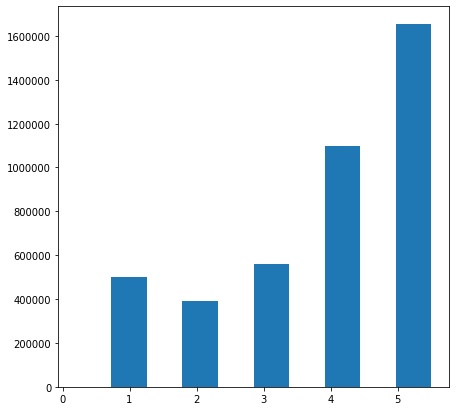

In [123]:
plt.figure(figsize=(7,7))
plt.hist(rest_review_csvTOpd.stars, range = (0.2,5.5), bins = 10)
plt.show()

In [140]:
# Random EDA
rest_review_length = len(rest_review_csvTOpd)
print("There are {} restaurant reviews.".format(rest_review_length))
testset = rest_review_csvTOpd[:1000]
category = testset.stars
testset.head()

There are 4201685 restaurant reviews.


,Unnamed: 0,review_id,business_id,stars,text
0,3,yi0R0Ugj_xUx_Nek0-_Qig,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
1,5,fdiNeiN_hoCxCMy2wTRW9g,eU_713ec6fTGNO4BegRaww,4.0,I'll be the first to admit that I was not exci...
2,6,G7XHMxG0bx9oBJNECG4IFg,3fw2X5bZYeW9xCz_zGhOHg,3.0,Tracy dessert had a big name in Hong Kong and ...
3,7,8e9HxxLjjqc9ez5ezzN7iQ,zvO-PJCpNk4fgAVUnExYAA,1.0,This place has gone down hill. Clearly they h...
4,10,kbtscdyz6lvrtGjD1quQTg,8mIrX_LrOnAqWsB5JrOojQ,4.0,"Like walking back in time, every Saturday morn..."


In [178]:
one_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 1.0]
two_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 2.0]
three_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 3.0]
four_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 4.0]
five_star = rest_review_csvTOpd.loc[rest_review_csvTOpd['stars'] == 5.0]

In [15]:
# Figuring out what percentage of the "rest_review_csvTOpd" should be training data, and what percentage should be test data.
num_train_data = int(rest_review_length * 0.8)
print("For 80% of the data, there should be {} reviews.".format(num_train_data))

For 80% of the data, there should be 3361348 reviews.


In [342]:
# Train data has equal amounts of each rating.
train_data = pd.concat([one_star.text[:1600], two_star.text[:1600], three_star.text[:1600], four_star.text[:1600], five_star.text[:1600]])
train_labels = pd.concat([one_star.stars[:1600], one_star.stars[:1600], three_star.stars[:1600], five_star.stars[:1600], five_star.stars[:1600]])

test_data = pd.concat([one_star.text[1600:1700], two_star.text[1600:1700], three_star.text[1600:1700], four_star.text[1600:1700], five_star.text[1600:1700]])
test_labels = pd.concat([one_star.stars[1600:1700], one_star.stars[1600:1700], three_star.stars[1600:1700], five_star.stars[1600:1700], five_star.stars[1600:1700]])

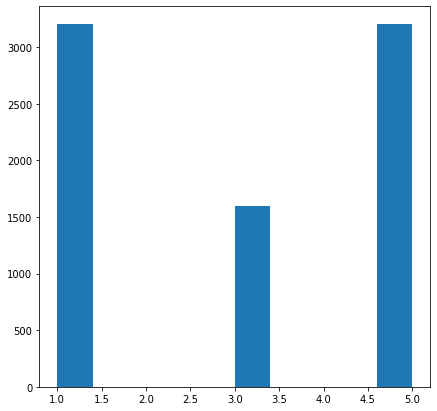

In [343]:
plt.figure(figsize=(7,7))
plt.hist(train_labels, range = (1,5), bins = 10)
plt.show()

In [344]:
# Fit CountVectorizer with your text data
vectorizer = CountVectorizer()
# train_data = testset.text.tolist()
vtrain = vectorizer.fit_transform(train_data)
vdev = vectorizer.transform(test_data)

In [369]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.09)
lr_classifier.fit(vtrain, train_labels)
train_predicted_labels = lr_classifier.predict(vdev)
f1_score = metrics.f1_score(test_labels, train_predicted_labels, average = 'weighted')
print(f1_score)

0.7645667436311591


In [350]:
lr_classifier.predict_proba(vdev)

array([[9.74598169e-01, 4.02074554e-05, 2.53616237e-02],
       [8.41955619e-01, 1.42672209e-01, 1.53721719e-02],
       [9.60548390e-01, 2.76008676e-02, 1.18507420e-02],
       ...,
       [5.33305275e-02, 4.74843169e-02, 8.99185156e-01],
       [9.11196862e-03, 2.27569638e-03, 9.88612335e-01],
       [6.11947559e-02, 3.65666845e-02, 9.02238560e-01]])

# Predictions without the neutral data

In [370]:
# Throwing away the neutral data
NO3_train_data = pd.concat([one_star.text[:1600], two_star.text[:1600], four_star.text[:1600], five_star.text[:1600]])
NO3_train_labels = pd.concat([one_star.stars[:1600], one_star.stars[:1600], five_star.stars[:1600], five_star.stars[:1600]])

NO3_test_data = pd.concat([one_star.text[1600:1700], two_star.text[1600:1700], four_star.text[1600:1700], five_star.text[1600:1700]])
NO3_test_labels = pd.concat([one_star.stars[1600:1700], one_star.stars[1600:1700], five_star.stars[1600:1700], five_star.stars[1600:1700]])

In [371]:
# Fit CountVectorizer with your text data
vectorizer = CountVectorizer()
# train_data = testset.text.tolist()
v_NO3_train = vectorizer.fit_transform(NO3_train_data)
v_NO3_dev = vectorizer.transform(NO3_test_data)

In [380]:
# Train LogisticRegression Classifier
lr_classifier = LogisticRegression(C=0.08)
lr_classifier.fit(v_NO3_train, NO3_train_labels)
train_predicted_labels = lr_classifier.predict(v_NO3_dev)
f1_score = metrics.f1_score(NO3_test_labels, train_predicted_labels, average = 'weighted')
print(f1_score)

0.917474726635032


* So if we throw out the moderate data (the 3-star reviews), it is clear that there is a difference between positive and negative reviews.

# Sample Prediction

In [351]:
# Predict new sentence
test_sentence = "I hate this place"
test_sentence = [test_sentence]

In [352]:
new_test = vectorizer.transform(test_sentence)
lr_classifier.predict(new_test)
lr_classifier.predict_proba(new_test)

array([[0.55746564, 0.16803394, 0.27450042]])

# Word Cloud